# Introduction/Purpose

The most common cancer in the United States is skin cancer, with a prevalence of 20% by the age of 70. Early detection is essential for prompt treatment and survival. A model to predict malignant skin cancer from at-home images can accelerate the process of seeking medical support.

### Import Libraries

In [1]:
# Standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch/torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Load + Wrangle Data

In [2]:
# Image preprocessing; resize to 224 x 224 pixels, convert image to PyTorch tensor, normalize pixel values

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

##### Load first image dataset

In [3]:
# Load data, assign labels from folder names, transform images

data_dir = './Malignant_vs_Benign_Skin_Cancer/Data - Unsplit'

dataset1 = datasets.ImageFolder(root=data_dir, transform=transform)

In [4]:
# Split into train and test sets

test_split = 0.2
total_size = len(dataset1)
test_size = int(test_split * total_size)
train_size = total_size - test_size

torch.manual_seed(42) 
train_dataset1, test_dataset1 = random_split(dataset1, [train_size, test_size])

##### Load second image dataset

In [5]:
# Map labels from .csv file to images

from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomImageDataset(Dataset):
    # Initialize dataset
    def __init__(self, img_dir, label_file, transform=transform):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(label_file)
        self.labels_df.columns = self.labels_df.columns.str.strip().str.lower()

    # Number of samples in dataset
    def __len__(self):
        return len(self.labels_df)

    # Returns one image/label at a time; required by all PyTorch Dataset objects
    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_id'] + '.jpg')

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"File not found: {img_path}")
        
        temp_label = row['dx'] 
        if temp_label in ['akiec', 'bcc', 'mel']:
            label = 1
        else:
            label = 0

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [6]:
# Create dataset labels

dataset2 = CustomImageDataset(
    img_dir=r'.\Skin Cancer MNIST HAM10000\Images', 
    label_file=r'.\Skin Cancer MNIST HAM10000\Original Data\HAM10000_metadata.csv', 
    transform=transform
)

In [7]:
# Split into train and test sets

test_split = 0.2
total_size = len(dataset2)
test_size = int(test_split * total_size)
train_size = total_size - test_size

torch.manual_seed(42) 
train_dataset2, test_dataset2 = random_split(dataset2, [train_size, test_size])

##### Concatenate datasets, create DataLoaders

In [8]:
# Concatenate datasets

from torch.utils.data import ConcatDataset

merged_train_dataset = ConcatDataset([train_dataset1, train_dataset2])
merged_test_dataset = ConcatDataset([test_dataset1, test_dataset2])

### EDA

*Are the classes balanced?*

Dataset 1:
Benign: 1800 images
Malignant: 1497 images
Approximately balanced

Dataset 2:


In [9]:
labels_df = pd.read_csv(r'.\Skin Cancer MNIST HAM10000\Original Data\HAM10000_metadata.csv')

In [10]:
labels_df.columns = labels_df.columns.str.strip().str.lower()

In [11]:
labels_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [12]:
malignant_labels = ['akiec', 'bcc', 'mel']

In [13]:
# Count images
malignant_count = labels_df['dx'].isin(malignant_labels).sum()
benign_count = len(labels_df) - malignant_count

print(f"Malignant images: {malignant_count}")
print(f"Benign images: {benign_count}")

Malignant images: 1954
Benign images: 8061


In [14]:
print(f"Malignant %: {(malignant_count/(malignant_count+benign_count))*100:.2f}%")

Malignant %: 19.51%


Class imbalance in 2nd dataset

In [15]:
print(f"Malignant % in combined dataset: {((1497+malignant_count)/(1800+1497+malignant_count+benign_count))*100:.2f}%")

Malignant % in combined dataset: 25.92%


Mild class imbalance in overall dataset; to be accounted for in upcoming steps

[Class imbalance % criteria](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets)

In [16]:
labels = [label for _, label in merged_train_dataset]

In [17]:
class_weights = {0: 1/9861, 1: 1/3451}

In [18]:
sample_weights = [class_weights[label] for label in labels]

In [19]:
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [20]:
# Create DataLoaders to feed data into model during training

train_loader = DataLoader(merged_train_dataset, batch_size=32, sampler = sampler)
test_loader = DataLoader(merged_test_dataset, batch_size=32, shuffle=False)

*Do the images contain enough variety?*


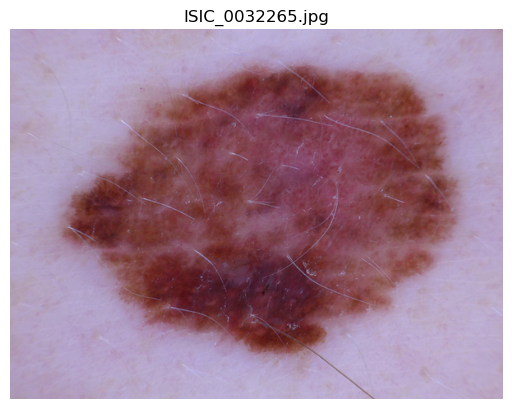

In [21]:
import random

image_files = labels_df['image_id']

random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)

# Display random image
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

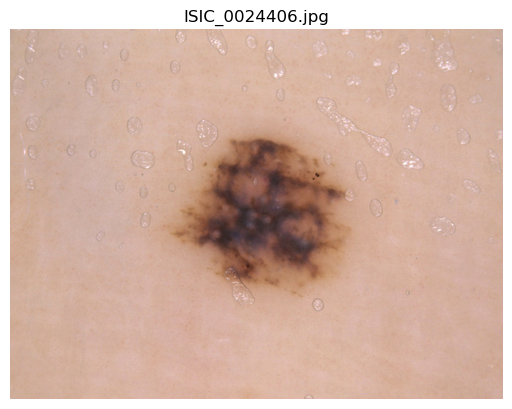

In [22]:
random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

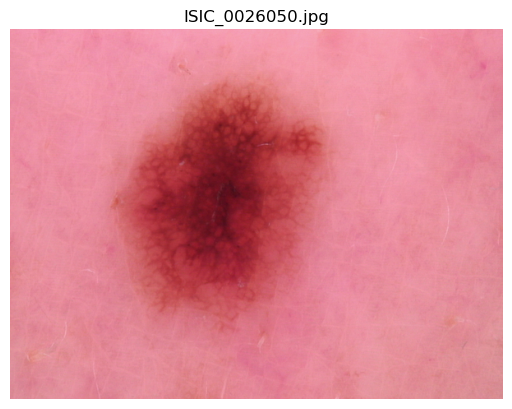

In [23]:
random_img = random.choice(image_files)+'.jpg'
img_path = os.path.join(r'.\Skin Cancer MNIST HAM10000\Images', random_img)
image = Image.open(img_path)
plt.imshow(image)
plt.title(random_img)
plt.axis("off")
plt.show()

Both datasets show wide variety in shape, color, and appearance/no appearance of hair. However, there is less variety in skin tone and the model may not generalize well to those with darker skin tones.

*Image formats and resolutions*

Images resized in Data Wrangling step; all images are .jpg

### Pre-Processing

Resizing, normalizing, tensor conversion performed in previous steps; data augmentation not needed due to large size of dataset

### Modeling

##### Define the CNN

In [24]:
# Define a neural network class from nn.Module
class Net(nn.Module):
    # Initialize neural network
    def __init__(self):
        super().__init__()
        # Define convolutional layer
        self.conv1 = nn.Conv2d(3, 6, 5)
        # Define max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Define 2nd convolutional layer
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Define fully connected layers
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    # Define how data flows through network
    def forward(self, x):
        # ReLU activation + max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten tensor into 1D vector, keeping batch dimension intact
        x = torch.flatten(x, 1) 
        # Apply ReLU activation to fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # No activation for final layer
        x = self.fc3(x)
        x = x.squeeze(1)
        return x

# Instantiate model
net = Net()

##### Define a loss function and optimizer

In [25]:
# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

###### Train the model/CNN

In [26]:
epoch_loss_history = []

# loop over the dataset 2 times; note: additional epochs not calculated due to computational power of machine and quality of results
for epoch in range(2):  
    total_loss = 0.0
    total_samples = 0
    
    # Loop over training data
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Ensure labels are floats
        labels = labels.float()

        # Reset the parameter gradients to prevent accumulation from previous batches
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs) # Pass inputs through network, generates predictions for each image
        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backpropagation to compute gradients for each parameter in the network based on the loss
        optimizer.step() # Apply gradient updates to improve the model's parameters

        batch_size = inputs.size(0)
        total_loss += loss.item() * batch_size  # Multiply by batch size to get the sum for this batch
        total_samples += batch_size
    
    epoch_loss = total_loss / total_samples  # Average loss over epoch
    epoch_loss_history.append({ # Save metric
        'epoch': epoch + 1,
        'avg_loss': epoch_loss
    })
    print(f'Epoch Loss: {epoch_loss:.3f}')

Epoch Loss: 0.673
Epoch Loss: 0.555


In [27]:
# Save trained model
PATH = './skin_cancer.pth'
torch.save(net.state_dict(), PATH)

##### Test the network

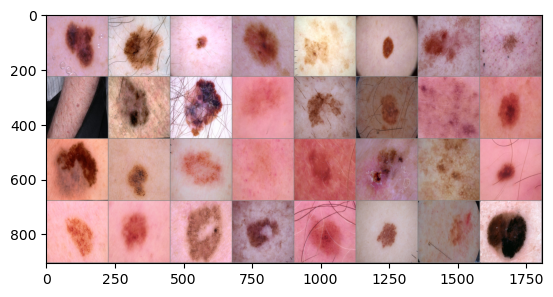

GroundTruth:  malignant malignant malignant malignant malignant benign malignant malignant malignant malignant
Predicted:  malignant malignant malignant malignant malignant malignant malignant malignant malignant malignant


In [28]:
classes = ('benign', 'malignant')
dataiter = iter(test_loader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid(images)

npimg = grid.numpy().transpose((1, 2, 0))

# Function to unnormalize the image tensor
def unnormalize(img):
    img = img * 0.5 + 0.5  # reverse the normalization
    return img

# Unnormalize the grid before converting to numpy array
grid = unnormalize(grid)
npimg = grid.numpy().transpose((1, 2, 0))

plt.imshow(npimg)
plt.show()

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(10)))

outputs = net(images)

predicted = (torch.sigmoid(outputs) > 0.2).long()

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(10)))

##### Evaluate on training data

In [29]:
test_labels = []
test_preds = []

for images, labels in test_loader:
    outputs = net(images)
    predicted = (torch.sigmoid(outputs) > 0.2).long()
    test_labels.extend(labels.cpu().numpy())
    test_preds.extend(predicted.cpu().numpy())

In [30]:
# Note: optimized threshold for torch.sigmoid(outputs) to maximize recall due to high risk if missing a malignant case

##### Save model metrics file

In [31]:
results = classification_report(test_labels, test_preds, output_dict = True)

In [32]:
print(classification_report(test_labels, test_preds))

              precision    recall  f1-score   support

           0       0.97      0.40      0.56      1960
           1       0.36      0.97      0.53       702

    accuracy                           0.55      2662
   macro avg       0.67      0.68      0.55      2662
weighted avg       0.81      0.55      0.55      2662



In [33]:
results = pd.DataFrame(results).transpose()

In [34]:
results = results.to_csv(index = True)

In [35]:
epoch_loss_history = pd.DataFrame(epoch_loss_history)

epoch_loss_history = epoch_loss_history.to_csv(index = False)

In [36]:
# Combine the CSV strings into a single string
combined_csv = "=== Classification Report ===\n" + results + "\n=== Epoch Loss History ===\n" + epoch_loss_history

# Write the combined string to a file
with open("model_metrics.csv", "w") as f:
    f.write(combined_csv)

In [37]:
# Train on GPU

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [39]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [40]:
inputs, labels = data[0].to(device), data[1].to(device)